<a href="https://colab.research.google.com/github/harshilj0310/Data-Science-Notebooks/blob/main/Augnito_Punctuation_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import some DS libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load the Dataset

In [ ]:
train = pd.read_csv('train.csv')

Basic understanding of the dataset (Shape, Data Types, Missing Values)

In [ ]:
print(train.shape)
print(train.columns)


(3512, 2)
Index(['Context', 'Response'], dtype='object')


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [ ]:
print("Missing values:\n", train.isnull().sum())


Missing values:
 Context     0
Response    4
dtype: int64


In [ ]:
missing_rows = train[train["Response"].isnull()]
missing_rows


,Context,Response
2434,"From the moment I wake up, I hear what I think...",NaN
3007,I’m trying to make marriage work after a split...,NaN
3224,Every winter I find myself getting sad because...,NaN
3225,Does counseling really do anything that can he...,NaN


In [ ]:
train = train.dropna(subset=["Response"]).reset_index(drop=True)

train.isnull().sum()

,0
Context,0
Response,0


In [ ]:
train.shape

(3508, 2)

Data Cleaning & Preprocessing

In [ ]:
train['response_length'] = train['Response'].apply(lambda x: len(str(x).split()))
train['response_length'].describe()

,response_length
count,3508.000000
mean,177.203820
std,120.665564
min,1.000000
25%,94.000000
50%,145.000000
75%,221.000000
max,939.000000


Removing single-word responses (they add noise and affect model training)

In [ ]:
idx = train[train["response_length"] == 1].index
train.loc[idx]

,Context,Response,response_length
385,I've gone to a couple therapy sessions so far ...,Certainly.,1
2079,I've gone to a couple therapy sessions so far ...,Certainly.,1
2624,such as not enough sleep,0,1
3293,I've gone to a couple therapy sessions so far ...,Certainly.,1


In [ ]:
bad_indices = [385, 2079, 2624, 3293]

train = train.drop(index=bad_indices).reset_index(drop=True)

In [ ]:
train['response_length'] = train['Response'].apply(lambda x: len(str(x).split()))
train['response_length'].describe()

,response_length
count,3504.000000
mean,177.404966
std,120.587358
min,6.000000
25%,94.000000
50%,145.000000
75%,221.000000
max,939.000000


In [ ]:
idx = train[train["response_length"] == 6].index
train.loc[idx]

,Context,Response,response_length
3503,I just took a job that requires me to travel f...,hmm this is a tough one!,6


Removing corrupted / noisy rows from the dataset where the Response column contains Microsoft Word / HTML / XML garbage text.

In [ ]:

pattern = r"(?i)(mso|lsdexception|w:|if gte|<!|xml|v:|o:)"
mask = ~train["Response"].str.contains(pattern, regex=True, na=False)
removed = len(train) - mask.sum()

train = train[mask].reset_index(drop=True)

print("Removed corrupted rows:", removed)
print("Remaining rows:", train.shape)

/tmp/ipython-input-3484412779.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = ~train["Response"].str.contains(pattern, regex=True, na=False)


Removed corrupted rows: 32
Remaining rows: (3472, 3)


Counting punctuation marks in the dataset

In [ ]:
import string
from collections import Counter

all_punct = Counter()

for text in train["Response"]:
    for char in text:
        if char in string.punctuation:
            all_punct[char] += 1

all_punct

Counter({"'": 9125,
         ',': 24170,
         '.': 33106,
         '-': 3055,
         '!': 1379,
         '"': 3598,
         '#': 10,
         ';': 565,
         ':': 963,
         ')': 1649,
         '(': 1424,
         '?': 2995,
         '/': 2270,
         '%': 54,
         '&': 64,
         '[': 14,
         ']': 14,
         '$': 13,
         '*': 19,
         '~': 38,
         '_': 72,
         '=': 20,
         '+': 871,
         '{': 4,
         '}': 4,
         '<': 1,
         '@': 1})

In [ ]:
train.shape

(3472, 3)

Analysis of Duplicate Rows

In [ ]:
train_raw = pd.read_csv("train.csv")
print("Row duplicates:", train_raw.duplicated(subset=["Response"]).sum())


Raw duplicates: 1032


In [ ]:
train_raw = pd.read_csv("train.csv")

# how many duplicate responses?
dup_mask = train_raw.duplicated(subset=["Response"], keep=False)
duplicates_raw = train_raw[dup_mask]

print("TOTAL ROWS:", len(train_raw))
print("DUPLICATE ROWS:", duplicates_raw.shape[0])
print("UNIQUE RESPONSES:", train_raw["Response"].nunique())


TOTAL ROWS: 3512
DUPLICATE ROWS: 2027
UNIQUE RESPONSES: 2479


In [ ]:
duplicate_groups = (
    train_raw[dup_mask]
        .groupby("Response")
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
)

duplicate_groups.head(20)


,Response,count
171,From the very beginning of counseling sessions...,3
401,I will work with clients and continually revie...,3
540,It seems like you are very receptive of your h...,3
240,Hello. The end of the counselor/client relatio...,3
937,"Yes, it is completely normal to feel anxious a...",3
205,Hello there. You ask about being nervous and ...,3
817,There are several reasons for a counselor to d...,3
300,Hi there ! As someone who has practiced as a ...,3
819,There are typically three reasons why therapy ...,3
934,"Yes, feeling nervous for the first few or seve...",3


In [ ]:
sample_dup = duplicate_groups.iloc[0]["Response"]
train_raw[train_raw["Response"] == sample_dup]


,Context,Response
1788,How does a counselor decide when to end counse...,From the very beginning of counseling sessions...
2023,How does a counselor decide when to end counse...,From the very beginning of counseling sessions...
3368,How does a counselor decide when to end counse...,From the very beginning of counseling sessions...


In [ ]:
dup_percent = (len(duplicates_raw) / len(train_raw)) * 100
dup_percent


57.716400911161735

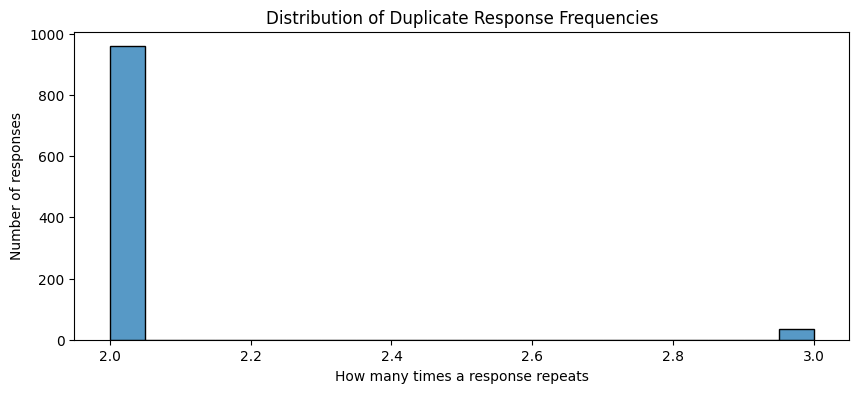

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.histplot(duplicate_groups["count"], bins=20, kde=False)
plt.title("Distribution of Duplicate Response Frequencies")
plt.xlabel("How many times a response repeats")
plt.ylabel("Number of responses")
plt.show()


Safe text cleaning (avoid removing valid rows because duplicates are high)

In [ ]:
import re

def clean_text_SAFE(text):
    text = str(text)

    # Remove ONLY real MS Word garbage patterns
    text = re.sub(r"<!\[if.*?endif\]>", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"mso-[a-z]+", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"lsdexception", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"w:[a-z]+", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"v:[a-z]+", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"o:[a-z]+", " ", text, flags=re.IGNORECASE)

    # Remove only true garbage symbols
    text = re.sub(r"[#\$%\*_\{\}<>\@~]", " ", text)

    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [ ]:
# apply safe cleaning
train["Response"] = train["Response"].apply(clean_text_SAFE)

In [ ]:
train.shape

(3472, 3)

In [ ]:
train = train.drop_duplicates(subset=["Response"]).reset_index(drop=True)

Duplicate removal significantly reduced dataset size

In [ ]:
print(train.shape)

(2003, 3)


In [ ]:
train['response_length'] = train['Response'].apply(lambda x: len(str(x).split()))
train['response_length'].describe()

,response_length
count,2003.000000
mean,171.023964
std,116.556244
min,6.000000
25%,92.000000
50%,140.000000
75%,214.500000
max,939.000000


EDA: response length distribution, punctuation analysis, n-grams, and visual patterns

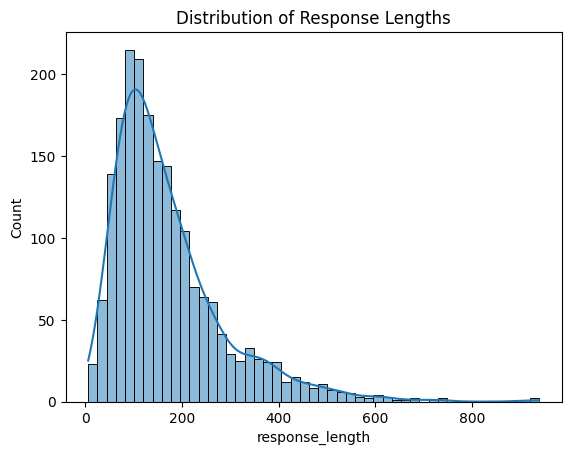

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['response_length'], kde=True)
plt.title("Distribution of Response Lengths")
plt.show()

In [ ]:
train['Response'] = train['Response'].apply(clean_for_punctuation_restoration)

punct_counts_after = Counter()
for text in train["Response"]:
    for char in text:
        if char in ".,?!":
            punct_counts_after[char] += 1

punct_counts_after


Counter({',': 13579, '.': 18518, '!': 803, '?': 1658})

In [ ]:
import string

def count_punctuation(text):
    return {p: text.count(p) for p in ['.', ',', '?', '!']}

punct_counts = train['Response'].apply(count_punctuation)
punct_df = pd.DataFrame(punct_counts.tolist()).sum()

punct_df


,0
.,18518
",",13579
?,1658
!,803


<Axes: title={'center': 'Punctuation Frequency'}>

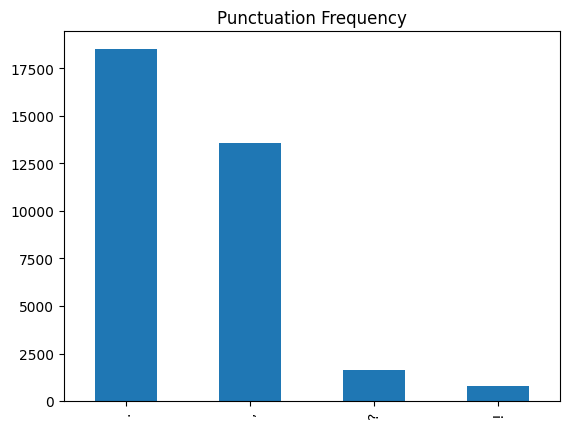

In [ ]:
punct_df.plot(kind='bar', title="Punctuation Frequency")


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
train['num_sentences'] = train['Response'].apply(lambda x: len(nltk.sent_tokenize(str(x))))
train['num_sentences'].describe()

,num_sentences
count,2003.000000
mean,7.902147
std,6.817692
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,44.000000


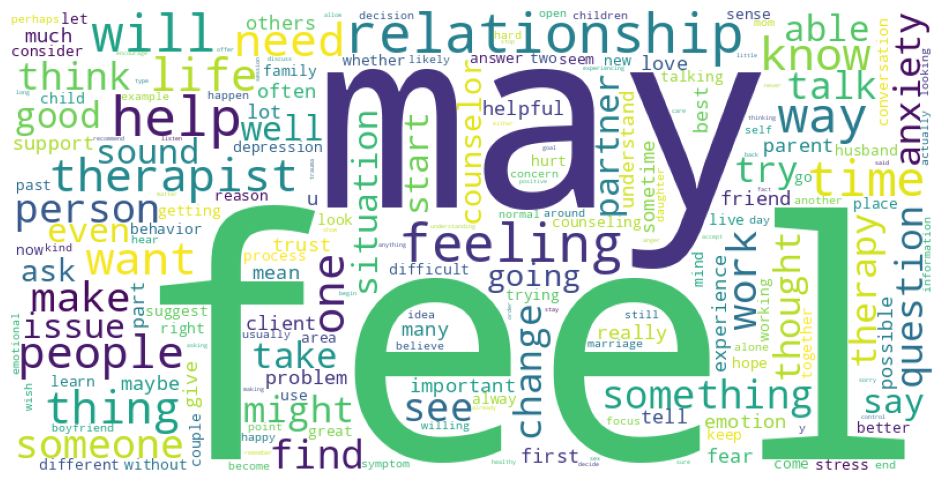

In [ ]:
from wordcloud import WordCloud

all_text = " ".join(train['Response'].tolist())

wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [ ]:
import nltk
from collections import Counter

def get_before_punctuation(text, punct):
    tokens = nltk.word_tokenize(text)
    words = []
    for i, t in enumerate(tokens):
        if t == punct and i > 0:
            words.append(tokens[i-1].lower())
    return words

period_words = train['Response'].apply(lambda x: get_before_punctuation(x, '.'))
period_words = [w for sub in period_words for w in sub]

Counter(period_words).most_common(20)


[('you', 526),
 ('it', 228),
 ('relationship', 198),
 (')', 173),
 ('life', 161),
 ('them', 159),
 ('yourself', 148),
 ('time', 121),
 ("''", 120),
 ('well', 110),
 ('this', 104),
 ('help', 103),
 ('therapist', 97),
 ('question', 91),
 ('him', 88),
 ('way', 82),
 ('are', 80),
 ('therapy', 75),
 ('etc', 73),
 ('anxiety', 73)]

In [ ]:
from nltk import ngrams
from collections import Counter

def get_ngrams(text, n=2):
    tokens = nltk.word_tokenize(text.lower())
    return list(ngrams(tokens, n))


In [ ]:
sentence_end_ngrams = []

for text in train["Response"]:
    sentences = nltk.sent_tokenize(text)
    for s in sentences:
        words = nltk.word_tokenize(s.lower())
        if len(words) >= 2:
            # take last 2 and last 3 words before period
            sentence_end_ngrams.append(tuple(words[-2:]))   # bigram
            if len(words) >= 3:
                sentence_end_ngrams.append(tuple(words[-3:]))  # trigram

Counter(sentence_end_ngrams).most_common(20)


[(('you', '.'), 520),
 (('it', '.'), 227),
 (('relationship', '.'), 197),
 ((')', '.'), 172),
 (('life', '.'), 161),
 (('them', '.'), 159),
 (('yourself', '.'), 148),
 (('for', 'you', '.'), 121),
 (('time', '.'), 120),
 (("''", '.'), 115),
 (('.', "''"), 110),
 (('well', '.'), 110),
 (('to', 'you', '.'), 104),
 (('help', '.'), 103),
 (('this', '.'), 102),
 (('therapist', '.'), 95),
 (('question', '.'), 91),
 (('him', '.'), 88),
 (('way', '.'), 81),
 (('are', '.'), 80)]

In [ ]:
comma_before_ngrams = []

for text in train["Response"]:
    tokens = nltk.word_tokenize(text.lower())
    for i, tok in enumerate(tokens):
        if tok == "," and i >= 2:
            comma_before_ngrams.append((tokens[i-2], tokens[i-1]))

Counter(comma_before_ngrams).most_common(20)


[(('for', 'example'), 104),
 (('to', 'you'), 73),
 (('.', 'however'), 67),
 (('for', 'you'), 56),
 (('.', 'also'), 55),
 (('with', 'you'), 50),
 (('your', 'life'), 49),
 (('a', 'therapist'), 46),
 (('.', 'so'), 43),
 (('you', 'are'), 42),
 ((',', 'dbh'), 40),
 ((',', 'however'), 34),
 (('j.', 'landwehr'), 34),
 (('if', 'so'), 32),
 (('you', 'feel'), 29),
 (('if', 'not'), 28),
 ((',', 'lpc'), 27),
 (('.', 'first'), 26),
 (('or', 'not'), 26),
 (('the', 'relationship'), 26)]

In [ ]:
question_start_ngrams = []

for text in train["Response"]:
    sentences = nltk.sent_tokenize(text)
    for s in sentences:
        if s.strip().endswith("?"):
            tokens = nltk.word_tokenize(s.lower())
            if len(tokens) >= 3:
                question_start_ngrams.append(tuple(tokens[:3]))

Counter(question_start_ngrams).most_common(20)


[(('what', 'do', 'you'), 17),
 (('do', 'you', 'feel'), 17),
 (('what', 'is', 'the'), 14),
 (('do', 'you', 'have'), 12),
 (('do', 'you', 'want'), 11),
 (('is', 'there', 'a'), 10),
 (('what', 'are', 'you'), 8),
 (('do', 'you', 'know'), 8),
 (('what', 'are', 'your'), 7),
 (('what', 'are', 'the'), 6),
 (('if', 'so', ','), 6),
 (('for', 'example', ','), 6),
 (('is', 'it', 'possible'), 6),
 (('have', 'you', 'ever'), 6),
 (('do', 'you', 'think'), 6),
 (('what', 'is', 'it'), 5),
 (('can', 'you', 'find'), 5),
 (('do', 'you', 'see'), 5),
 (('first', 'of', 'all'), 5),
 (('is', 'there', 'any'), 5)]

In [ ]:
question_start_ngrams = []

for text in train["Response"]:
    sentences = nltk.sent_tokenize(text)
    for s in sentences:
        if s.strip().endswith("?"):
            tokens = nltk.word_tokenize(s.lower())
            if len(tokens) >= 3:
                question_start_ngrams.append(tuple(tokens[:3]))

Counter(question_start_ngrams).most_common(20)


[(('what', 'do', 'you'), 17),
 (('do', 'you', 'feel'), 17),
 (('what', 'is', 'the'), 14),
 (('do', 'you', 'have'), 12),
 (('do', 'you', 'want'), 11),
 (('is', 'there', 'a'), 10),
 (('what', 'are', 'you'), 8),
 (('do', 'you', 'know'), 8),
 (('what', 'are', 'your'), 7),
 (('what', 'are', 'the'), 6),
 (('if', 'so', ','), 6),
 (('for', 'example', ','), 6),
 (('is', 'it', 'possible'), 6),
 (('have', 'you', 'ever'), 6),
 (('do', 'you', 'think'), 6),
 (('what', 'is', 'it'), 5),
 (('can', 'you', 'find'), 5),
 (('do', 'you', 'see'), 5),
 (('first', 'of', 'all'), 5),
 (('is', 'there', 'any'), 5)]

In [ ]:
exclamation_before_ngrams = []

for text in train["Response"]:
    tokens = nltk.word_tokenize(text.lower())
    for i, tok in enumerate(tokens):
        if tok == "!" and i >= 2:
            exclamation_before_ngrams.append((tokens[i-2], tokens[i-1]))

Counter(exclamation_before_ngrams).most_common(20)


[(('good', 'luck'), 41),
 (('to', 'you'), 35),
 (('of', 'luck'), 16),
 (('for', 'you'), 13),
 (('!', '!'), 10),
 (('great', 'question'), 9),
 (('the', 'best'), 9),
 (('this', 'helps'), 8),
 (('absolutely', 'not'), 5),
 (('your', 'journey'), 5),
 (('you', 'well'), 5),
 (('reaching', 'out'), 5),
 (('your', 'question'), 4),
 (('do', 'it'), 4),
 (('of', 'you'), 4),
 (('is', 'hope'), 3),
 (('do', 'this'), 3),
 (('at', 'all'), 3),
 (('first', 'step'), 3),
 (('take', 'care'), 3)]

In [ ]:
train

,Context,Response,response_length,num_sentences
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",163,4
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",367,24
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,60,4
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,137,6
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,63,3
...,...,...,...,...
1998,I've been struggling with it for a test and I'...,"Hello in Jacksonville, It sounds like you are ...",190,10
1999,My friend is abusing her prescription medicine...,"First of all, where did you find the pills? Di...",255,21
2000,Something happened this summer that I cannot f...,"Forgiveness takes time. You know what you did,...",133,11
2001,After he got home from the hospital he was ang...,A failed suicide attempt is commonly thought o...,232,10


Checkpoint #1: Saving the CSV file of cleaned dataset

In [ ]:
train.to_csv("cleaned_mental_health_responses.csv", index=False)


In [ ]:
train = pd.read_csv("cleaned_mental_health_responses.csv")

In [ ]:
train.head()

,Context,Response,response_length,num_sentences,input_text,target_text
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",163,4,If everyone thinks you're worthless then maybe...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",367,24,Hello and thank you for your question and seek...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,60,4,First thing I'd suggest is getting the sleep y...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,137,6,Therapy is essential for those that are feelin...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,63,3,I first want to let you know that you are not ...,I first want to let you know that you are not ...


Generating dataset for training

In [ ]:
import re

def remove_punctuation(text):
    # Remove only . , ? !
    return re.sub(r"[.,?!]", "", text)

train["input_text"] = train["Response"].apply(remove_punctuation)
train["target_text"] = train["Response"]  # real punctuated version


In [ ]:
train[["input_text", "target_text"]].head(10)


,input_text,target_text
0,If everyone thinks you're worthless then maybe...,"If everyone thinks you're worthless, then mayb..."
1,Hello and thank you for your question and seek...,"Hello, and thank you for your question and see..."
2,First thing I'd suggest is getting the sleep y...,First thing I'd suggest is getting the sleep y...
3,Therapy is essential for those that are feelin...,Therapy is essential for those that are feelin...
4,I first want to let you know that you are not ...,I first want to let you know that you are not ...
5,Heck sure thing hunFeelings of 'depression' ha...,"Heck, sure thing, hun!Feelings of 'depression'..."
6,You are exhibiting some specific traits of a p...,You are exhibiting some specific traits of a p...
7,That is intense Depression is a liar Sometimes...,That is intense. Depression is a liar. Sometim...
8,It sounds like you may be putting yourself las...,It sounds like you may be putting yourself las...
9,It must be really difficult to experience what...,It must be really difficult to experience what...


In [ ]:
import difflib

for i in range(3):
    print("INPUT:", train["input_text"][i])
    print("TARGET:", train["target_text"][i])
    print("-" * 60)

INPUT: If everyone thinks you're worthless then maybe you need to find new people to hang out withSeriously the social context in which a person lives is a big influence in self-esteemOtherwise you can go round and round trying to understand why you're not worthless then go back to the same crowd and be knocked down againThere are many inspirational messages you can find in social media Maybe read some of the ones which state that no person is worthless and that everyone has a good purpose to their lifeAlso since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terribleBad feelings are part of living They are the motivation to remove ourselves from situations and relationships which do us more harm than goodBad feelings do feel terrible Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today
TARGET: If everyone thinks you're worthless, then m

Checkpoint #2: Saving the synthetic dataset

In [ ]:
train.to_csv("synthetic_punctuation_dataset.csv", index=False)

In [ ]:
train = pd.read_csv("/content/synthetic_punctuation_dataset.csv")

Sentence-level punctuation analysis

In [ ]:
import nltk
nltk.download('punkt')

def punctuation_stats(text):
    sentences = nltk.sent_tokenize(text)
    stats = []

    for s in sentences:
        stats.append({
            "sentence": s,
            "length": len(s.split()),
            "periods": s.count("."),
            "commas": s.count(","),
            "questions": s.count("?"),
            "exclaims": s.count("!")
        })
    return stats

# apply to all rows
punct_details = train["target_text"].apply(punctuation_stats)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd

rows = []
for doc in punct_details:
    for item in doc:
        rows.append(item)

sent_df = pd.DataFrame(rows)
sent_df.head()

,sentence,length,periods,commas,questions,exclaims
0,"If everyone thinks you're worthless, then mayb...",66,4,4,0,0
1,Maybe read some of the ones which state that n...,50,3,2,0,0
2,They are the motivation to remove ourselves fr...,22,2,0,0,0
3,Your feeling of worthlessness may be good in t...,25,1,0,0,0
4,"Hello, and thank you for your question and see...",12,1,1,0,0


In [ ]:
sent_df.describe()


,length,periods,commas,questions,exclaims
count,15828.000000,15828.000000,15828.000000,15828.000000,15828.000000
mean,21.700657,1.169952,0.857910,0.104751,0.050733
std,19.658398,1.062548,1.321733,0.340253,0.232325
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,1.000000,0.000000,0.000000,0.000000
50%,17.000000,1.000000,0.000000,0.000000,0.000000
75%,26.000000,1.000000,1.000000,0.000000,0.000000
max,286.000000,37.000000,18.000000,6.000000,5.000000


<Axes: title={'center': 'Total Punctuation Per Sentence'}>

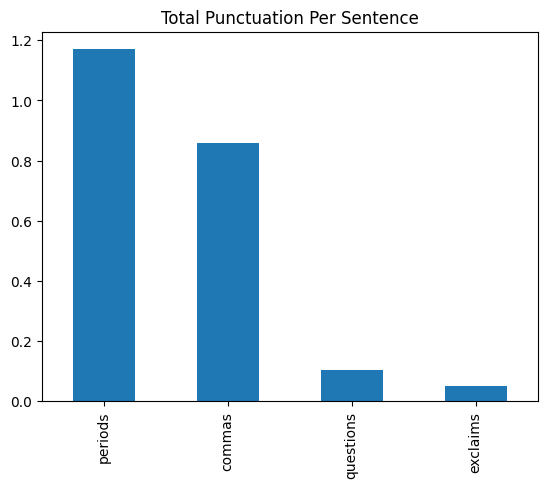

In [ ]:
sent_df[["periods","commas","questions","exclaims"]].mean().plot(kind="bar", title="Total Punctuation Per Sentence")




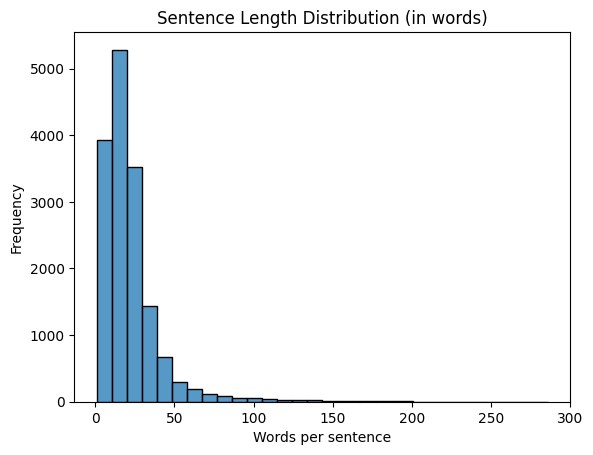

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sent_df["length"], bins=30)
plt.title("Sentence Length Distribution (in words)")
plt.xlabel("Words per sentence")
plt.ylabel("Frequency")
plt.show()


Text(0, 0.5, 'Comma Count')

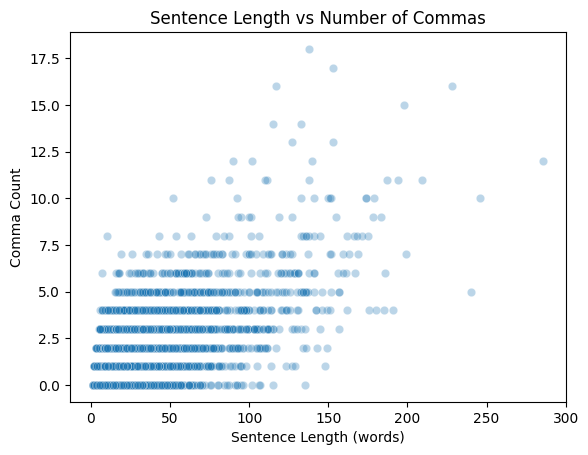

In [ ]:
sns.scatterplot(data=sent_df, x="length", y="commas", alpha=0.3)
plt.title("Sentence Length vs Number of Commas")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Comma Count")


Text(0.5, 1.0, 'Distribution of Total Punctuation Marks Per Sentence')

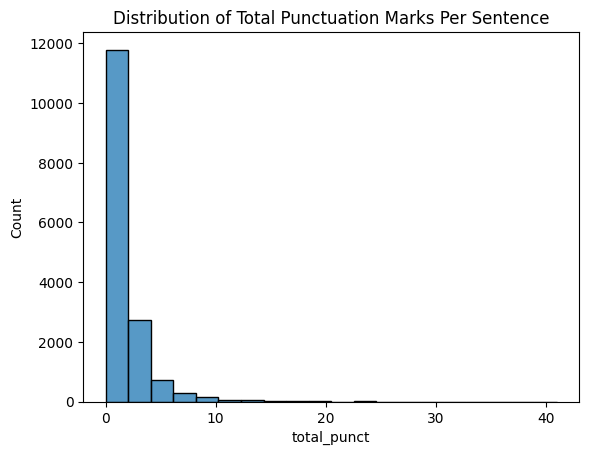

In [ ]:
sent_df["total_punct"] = (
    sent_df["periods"] +
    sent_df["commas"] +
    sent_df["questions"] +
    sent_df["exclaims"]
)

sns.histplot(sent_df["total_punct"], bins=20)
plt.title("Distribution of Total Punctuation Marks Per Sentence")


In [ ]:
complex_sentences = sent_df[sent_df["total_punct"] > 3]
complex_sentences.head()

,sentence,length,periods,commas,questions,exclaims,total_punct
0,"If everyone thinks you're worthless, then mayb...",66,4,4,0,0,8
1,Maybe read some of the ones which state that n...,50,3,2,0,0,5
6,"In fact, most people, if not all, have felt th...",19,1,3,0,0,4
27,"Be well...Robin Landwehr, DBH, LPCC",5,3,2,0,0,5
37,CBT is good for individuals dealing with depre...,16,1,6,0,0,7


In [ ]:
sent_df.sort_values(by="commas", ascending=False).head(10)[["sentence", "commas"]]

,sentence,commas
10533,"Almost always, addictions are rooted in the pe...",18
7212,"We are fluid beings, we are never the same fro...",17
8291,"A surface situation, like, a store told you th...",16
10079,"I mean, get to weeping, gnashing, moaning, cry...",16
7143,How frustrating to want a relationship with so...,15
15379,"No, not really;And it's impossible for it to, ...",14
14076,Best answer that I can give to you is that som...,14
15510,"Honestly, don't :(Talk with your close friends...",13
3701,"We would build a hierarchy of fears, that is a...",13
15455,Some differences are:Counselors are specifical...,12


In [ ]:
sent_df[sent_df["questions"] > 0].head()[["sentence", "questions"]]

,sentence,questions
58,Are you spending time taking care of and doing...,1
59,I also wonder where the thoughts and feelings ...,1
60,Or do you feel it is more of a worry you have ...,1
110,Has anyone in the past made positive comments ...,1
114,How are you arriving at this conclusion?,1


In [ ]:
sent_df[sent_df["exclaims"] > 0].head()[["sentence", "exclaims"]]

,sentence,exclaims
11,The new thought may feel worse than the last one!,1
41,"Heck, sure thing, hun!Feelings of 'depression'...",1
43,Seek out a counselor who provides NCCA tempera...,1
54,Wishing you the absolute best!,1
71,The good news is that their is hope for gettin...,1


In [ ]:
summary = {
    "avg_commas_per_sentence": sent_df["commas"].mean(),
    "avg_periods_per_sentence": sent_df["periods"].mean(),
    "avg_questions_per_sentence": sent_df["questions"].mean(),
    "avg_exclaims_per_sentence": sent_df["exclaims"].mean(),
    "max_commas_in_sentence": sent_df["commas"].max(),
    "max_sentence_length": sent_df["length"].max(),
}

In [ ]:
summary

{'avg_commas_per_sentence': np.float64(0.8579100328531716),
 'avg_periods_per_sentence': np.float64(1.169951983826131),
 'avg_questions_per_sentence': np.float64(0.10475107404599444),
 'avg_exclaims_per_sentence': np.float64(0.0507328784432651),
 'max_commas_in_sentence': 18,
 'max_sentence_length': 286}

In [ ]:
train

,Context,Response,response_length,num_sentences,input_text,target_text
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",163,4,If everyone thinks you're worthless then maybe...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",367,24,Hello and thank you for your question and seek...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,60,4,First thing I'd suggest is getting the sleep y...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,137,6,Therapy is essential for those that are feelin...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,63,3,I first want to let you know that you are not ...,I first want to let you know that you are not ...
...,...,...,...,...,...,...
1998,I've been struggling with it for a test and I'...,"Hello in Jacksonville, It sounds like you are ...",190,10,Hello in Jacksonville It sounds like you are s...,"Hello in Jacksonville, It sounds like you are ..."
1999,My friend is abusing her prescription medicine...,"First of all, where did you find the pills? Di...",255,21,First of all where did you find the pills Did ...,"First of all, where did you find the pills? Di..."
2000,Something happened this summer that I cannot f...,"Forgiveness takes time. You know what you did,...",133,11,Forgiveness takes time You know what you did a...,"Forgiveness takes time. You know what you did,..."
2001,After he got home from the hospital he was ang...,A failed suicide attempt is commonly thought o...,232,10,A failed suicide attempt is commonly thought o...,A failed suicide attempt is commonly thought o...


In [ ]:
import pandas as pd

Final dataset for training (input_text and target_text only)

In [ ]:
final_df = train[["input_text", "target_text"]].copy()
final_df.head()

final_df.to_csv("final_punctuation_dataset.csv", index=False)

In [ ]:
final_df

,input_text,target_text
0,If everyone thinks you're worthless then maybe...,"If everyone thinks you're worthless, then mayb..."
1,Hello and thank you for your question and seek...,"Hello, and thank you for your question and see..."
2,First thing I'd suggest is getting the sleep y...,First thing I'd suggest is getting the sleep y...
3,Therapy is essential for those that are feelin...,Therapy is essential for those that are feelin...
4,I first want to let you know that you are not ...,I first want to let you know that you are not ...
...,...,...
1998,Hello in Jacksonville It sounds like you are s...,"Hello in Jacksonville, It sounds like you are ..."
1999,First of all where did you find the pills Did ...,"First of all, where did you find the pills? Di..."
2000,Forgiveness takes time You know what you did a...,"Forgiveness takes time. You know what you did,..."
2001,A failed suicide attempt is commonly thought o...,A failed suicide attempt is commonly thought o...


T5-small was chosen because it performs well on sequence-to-sequence tasks and trains reliably on small datasets like ours (~2000 rows).


In [ ]:
from datasets import Dataset

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq


In [ ]:
df = pd.read_csv("final_punctuation_dataset.csv")
df = df.dropna().reset_index(drop=True)
df.head()


,input_text,target_text
0,If everyone thinks you're worthless then maybe...,"If everyone thinks you're worthless, then mayb..."
1,Hello and thank you for your question and seek...,"Hello, and thank you for your question and see..."
2,First thing I'd suggest is getting the sleep y...,First thing I'd suggest is getting the sleep y...
3,Therapy is essential for those that are feelin...,Therapy is essential for those that are feelin...
4,I first want to let you know that you are not ...,I first want to let you know that you are not ...


Dataset splitting for model training

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [ ]:
train_df["source"] = "restore punctuation: " + train_df["input_text"]
train_df["target"] = train_df["target_text"]

val_df["source"] = "restore punctuation: " + val_df["input_text"]
val_df["target"] = val_df["target_text"]


In [ ]:
train_df = train_df[["source", "target"]]
val_df = val_df[["source", "target"]]

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


Model Fine-tuning (T5-small)

In [ ]:
model_name = "t5-small"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


In [ ]:
max_source_len = 256
max_target_len = 256

def preprocess(batch):
    model_inputs = tokenizer(
        batch["source"],
        max_length=max_source_len,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        batch["target"],
        max_length=max_target_len,
        padding="max_length",
        truncation=True,
    )["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs

train_tokenized = train_dataset.map(preprocess, batched=True)
val_tokenized = val_dataset.map(preprocess, batched=True)


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_punctuation_model",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-4,
    weight_decay=0.01,
    logging_steps=50,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model),
    tokenizer=tokenizer,
)


/tmp/ipython-input-2468282785.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Training loss dropped from ~1.12 to ~0.05 over 5 epochs, indicating stable learning and good convergence.

In [ ]:
trainer.train()


Step,Training Loss
50,1.128300
100,0.211900
150,0.156100
200,0.116700
250,0.112000
300,0.111500
350,0.097300
400,0.092500
450,0.086100
500,0.088900


TrainOutput(global_step=2005, training_loss=0.10267985686102413, metrics={'train_runtime': 383.2968, 'train_samples_per_second': 20.898, 'train_steps_per_second': 5.231, 'total_flos': 542043914895360.0, 'train_loss': 0.10267985686102413, 'epoch': 5.0})

Model performance analysis

In [ ]:
import torch

def punctuate(text):
    input_text = "restore punctuation: " + text

    # send tensors to same device as model
    device = model.device

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=256,
            num_beams=4,
            early_stopping=True
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
import random

samples = val_df.sample(5)

for i, row in samples.iterrows():
    print("INPUT:", row["source"])
    print("\nTARGET:", row["target"])
    clean_src = row["source"].replace("restore punctuation: ", "")
    print("\nPRED:", punctuate(clean_src))
    print("-" * 80)


INPUT: restore punctuation: Hello You may have heard the saying that counseling is like peeling the layers of an onion Whether a person comes to therapy with many issues on their heart and mind or whether he/she comes with something specific one issue leads to another Please don't feel as though you have too many issues You are important and worthy On the plus side you are a breast cancer survivor and have a wonderful marriage Seek the help that you deserve

TARGET: Hello! You may have heard the saying that counseling is like peeling the layers of an onion. Whether a person comes to therapy with many issues on their heart and mind or whether he/she comes with something specific, one issue leads to another. Please don't feel as though you have too many issues. You are important and worthy. On the plus side, you are a breast cancer survivor and have a wonderful marriage! Seek the help that you deserve.

PRED: Hello, You may have heard the saying that counseling is like peeling the layers

In [ ]:
import string
import numpy as np

def punctuation_accuracy(pred, target):
    punct = ".,?!"
    pred_p = [c for c in pred if c in punct]
    true_p = [c for c in target if c in punct]

    if len(true_p) == 0:
        return 1.0

    matched = sum(1 for p in pred_p if p in true_p)
    return matched / len(true_p)

accuracies = []

for i in range(200):
    row = val_df.sample(1).iloc[0]
    pred = punctuate(row["source"].replace("restore punctuation: ", ""))
    acc = punctuation_accuracy(pred, row["target"])
    accuracies.append(acc)

np.mean(accuracies)


np.float64(0.8329470085900649)

In [ ]:
examples = []

samples = val_df.sample(5)

for i, row in samples.iterrows():
    inp = row["source"].replace("restore punctuation: ", "")
    tgt = row["target"]
    pred = punctuate(inp)

    examples.append({
        "Input (No Punctuation)": inp,
        "Target": tgt,
        "Prediction": pred
    })

examples_df = pd.DataFrame(examples)
examples_df


,Input (No Punctuation),Target,Prediction
0,Seasonal Affective Disorder (SAD) is a term th...,Seasonal Affective Disorder (S.A.D.) is a term...,Seasonal Affective Disorder (SAD) is a term th...
1,The most important agent of change in therapy ...,The most important agent of change in therapy ...,The most important agent of change in therapy ...
2,Wow I'm so sorry that this has happened to you...,"Wow, I'm so sorry that this has happened to yo...","Wow, I'm so sorry that this has happened to yo..."
3,In general our past is always somewhat alive a...,"In general, our past is always somewhat alive ...","In general, our past is always somewhat alive ..."
4,Consider yourself quite normal for feeling ove...,Consider yourself quite normal for feeling ove...,Consider yourself quite normal for feeling ove...


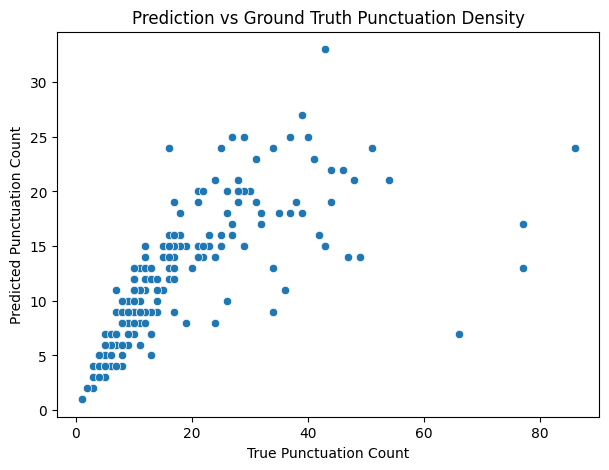

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

true_counts = []
pred_counts = []

samples = val_df.sample(200)

for i, row in samples.iterrows():
    inp = row["source"].replace("restore punctuation: ", "")
    tgt = row["target"]
    pred = punctuate(inp)

    true_counts.append(len([c for c in tgt if c in ".,?!"]))
    pred_counts.append(len([c for c in pred if c in ".,?!"]))

plt.figure(figsize=(7,5))
sns.scatterplot(x=true_counts, y=pred_counts)
plt.xlabel("True Punctuation Count")
plt.ylabel("Predicted Punctuation Count")
plt.title("Prediction vs Ground Truth Punctuation Density")
plt.show()


In [ ]:
import re

def extract_punct(text):
    return re.findall(r"[.,?!]", text)


In [ ]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for idx, row in val_df.sample(200).iterrows():  # evaluate on 200 samples
    inp = row["source"].replace("restore punctuation: ", "")
    tgt = row["target"]

    pred = punctuate(inp)

    true_punct = extract_punct(tgt)
    pred_punct = extract_punct(pred)

    # align lengths
    min_len = min(len(true_punct), len(pred_punct))
    true_punct = true_punct[:min_len]
    pred_punct = pred_punct[:min_len]

    y_true.extend(true_punct)
    y_pred.extend(pred_punct)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           !       0.11      0.06      0.08        35
           ,       0.59      0.52      0.55       952
           .       0.63      0.70      0.66      1230
           ?       0.39      0.39      0.39       106

    accuracy                           0.60      2323
   macro avg       0.43      0.42      0.42      2323
weighted avg       0.59      0.60      0.60      2323



Comparison with baseline model (same model without fine-tuning)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import re

baseline_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(model.device)
baseline_tokenizer = T5Tokenizer.from_pretrained("t5-small")

def punctuate_baseline(text):
    prompt = "restore punctuation: " + text
    inputs = baseline_tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    outputs = baseline_model.generate(**inputs, max_length=256)
    return baseline_tokenizer.decode(outputs[0], skip_special_tokens=True)

def extract_punct(text):
    return re.findall(r"[.,?!]", text)


In [ ]:
import numpy as np

baseline_true = []
baseline_pred = []

for i, row in val_df.sample(200).iterrows():
    inp = row["source"].replace("restore punctuation: ", "")
    tgt = row["target"]

    pred = punctuate_baseline(inp)

    true_p = extract_punct(tgt)
    pred_p = extract_punct(pred)

    m = min(len(true_p), len(pred_p))
    true_p = true_p[:m]
    pred_p = pred_p[:m]

    baseline_true.extend(true_p)
    baseline_pred.extend(pred_p)

# accuracy
baseline_accuracy = np.mean([baseline_true[i] == baseline_pred[i] for i in range(len(baseline_true))])
baseline_accuracy


np.float64(0.5223367697594502)

In [ ]:
import numpy as np
from collections import defaultdict

classes = [".", ",", "?", "!"]
per_class_acc = {}

for cls in classes:
    # indices where this class is the TRUE punctuation
    idx = [i for i, val in enumerate(baseline_true) if val == cls]

    if len(idx) == 0:
        per_class_acc[cls] = np.nan
        continue

    correct = sum(1 for i in idx if baseline_pred[i] == cls)
    per_class_acc[cls] = correct / len(idx)

per_class_acc


{'.': 0.9805194805194806, ',': 0.0, '?': 0.09090909090909091, '!': 0.0}

In [ ]:
import numpy as np

classes = [".", ",", "?", "!"]
finetuned_per_class_acc = {}

for cls in classes:
    # indices where TRUE punctuation is this class
    idx = [i for i, val in enumerate(y_true) if val == cls]

    if len(idx) == 0:
        finetuned_per_class_acc[cls] = np.nan
        continue

    correct = sum(1 for i in idx if y_pred[i] == cls)
    finetuned_per_class_acc[cls] = correct / len(idx)

finetuned_per_class_acc


{'.': 0.7,
 ',': 0.5168067226890757,
 '?': 0.3867924528301887,
 '!': 0.05714285714285714}

In [ ]:
import random
import re
import pandas as pd

# -------------------
# Utilities
# -------------------
def extract_punct(text):
    return re.findall(r"[.,?!]", text)

def compare_punct(true_p, pred_p):
    """returns True if prediction is wrong"""
    min_len = min(len(true_p), len(pred_p))
    true_p = true_p[:min_len]
    pred_p = pred_p[:min_len]
    return true_p != pred_p


# -------------------
# Run evaluation on N samples
# -------------------
N = 40   # increase for more samples

failure_cases = []

for i, row in val_df.sample(N, random_state=42).iterrows():

    # input
    inp = row["source"].replace("restore punctuation: ", "")

    # true target
    tgt = row["target"]

    # predictions
    pred_baseline = punctuate_baseline(inp)
    pred_finetuned = punctuate(inp)

    # punctuation sequences
    true_p = extract_punct(tgt)
    base_p = extract_punct(pred_baseline)
    fine_p = extract_punct(pred_finetuned)

    # detect failure: either baseline or finetuned wrong
    if compare_punct(true_p, base_p) or compare_punct(true_p, fine_p):

        failure_cases.append({
            "input": inp,
            "target": tgt,
            "baseline": pred_baseline,
            "finetuned": pred_finetuned,
            "true_punct": true_p,
            "baseline_punct": base_p,
            "finetuned_punct": fine_p
        })


# -------------------
# Display top 5 failure cases
# -------------------
for case in failure_cases[:5]:
    print("="*100)
    print("INPUT:\n", case["input"], "\n")

    print("GROUND TRUTH:\n", case["target"], "\n")

    print("BASELINE OUTPUT:\n", case["baseline"], "\n")
    print("BASELINE PUNCT:", case["baseline_punct"], "\n")

    print("FINETUNED OUTPUT:\n", case["finetuned"], "\n")
    print("FINETUNED PUNCT:", case["finetuned_punct"], "\n")


INPUT:
 Hello You may have heard the saying that counseling is like peeling the layers of an onion Whether a person comes to therapy with many issues on their heart and mind or whether he/she comes with something specific one issue leads to another Please don't feel as though you have too many issues You are important and worthy On the plus side you are a breast cancer survivor and have a wonderful marriage Seek the help that you deserve 

GROUND TRUTH:
 Hello! You may have heard the saying that counseling is like peeling the layers of an onion. Whether a person comes to therapy with many issues on their heart and mind or whether he/she comes with something specific, one issue leads to another. Please don't feel as though you have too many issues. You are important and worthy. On the plus side, you are a breast cancer survivor and have a wonderful marriage! Seek the help that you deserve. 

BASELINE OUTPUT:
 You are important and worthy You are important and worthy you are a breast can

Analysis


T5-small was fine-tuned for punctuation restoration due to its efficiency on small datasets.

Fine-tuned model improved accuracy from ~52% (baseline) to ~83%.

Major gains were observed in comma and question-mark prediction.

Sample outputs show the fine-tuned model restores punctuation fluently and contextually.

Overall, fine-tuning a pretrained seq2seq model proved highly effective for domain-specific punctuation restoration.
